# Timeseries data

In the current notebook, we will explore some of the nuances of the 'timeseries' dataset.  
This notebook will expand the EDA process for the individual datasets, focusing on investigating the interaction between different variables.  

The 'timeseries' dataset consists of the historical data of products orders. We track some measures like stocks, prices, competitor's prices, shipping values, order quantities over time, for 644 different products.

## TABLE OF CONTENTS

0. [Library and data imports](#library)  
1. [Dataset Exploration](#exploration)  
    1.1 Headers  
    1.2 Data types  
    1.3 Missing Values  
    1.4 Artificial columns  
    1.5 Summary statistics  
2. [Univariate Analysis](#univariate)  
    2.1 Prices (olist, competition, deltas)  
    2.2 Normalized Prices Grouped by Gtin, Product Type and Product Type Group.
    2.3 Shipping (freight ratio) 
    2.4 Scaled Shipping: values - Grouped by gtin, product_type and product_type_group    
    2.5 Orders  
3. [Bivariate Analysis](#bivariate)  
    3.1 Price x Orders  
    3.2 Shipping x Orders  
    3.3 Product Attributes x Orders  
4. [Demand Sparsity](#sparsity)  
    4.1 Demonstrate sparsity of sales inside product_groups and types; show that we have few gtins per category  
5. [Product Group Analysis](#group)  
6. [Product GTIN analysis](#gtin)  
    6.1 Makeup Kit  
7. [Product Type analysis](#product_type_group)  
    7.1 Makeup Kit  

<a name="library"></a>
### 0 - Imports and reading the data

Let's import some packages and read the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import minmax_scale

from matplotlib.dates import DateFormatter

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

%matplotlib inline

In [3]:
#df = pd.read_csv('https://bsa-correlation-one.s3.amazonaws.com/timeseries644.csv', dtype={'product_gtin':'str'})
df = pd.read_csv('../data/timeseries644.csv', dtype={'product_gtin':'str'})

<a name="exploration"></a>
### 1. Dataset exploration

At first, let's explore a few of the dataset's attributes. It is important to understand some of the column's information, data types, missing values and major statistics.


#### 1.1 Dataset Headers:

Each row of the dataset consists of the following information, for a given date: a product (gtin), the competition price and olist's price, the commission rates, the number of sales (orders), the product type and group, stock information and product's name and description.

In [4]:
df.head(3)

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description
0,2016-10-03,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
1,2016-10-04,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
2,2016-10-05,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...


#### 1.2 Dataset info:

We have 299941 rows, with 21 columns. Most of the columns are complete, but notice that freight_value and commission columns have only 6.26% of the rows with information (18875). This information is only available when orders were created for a given product, on any given day.  
Also, product_type and group are present in 71.4% of the rows (214135). This means that roughly 30% of the products were not being sold in 1Q of 2020, when the categorization system was created.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299941 entries, 0 to 299940
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date                      299941 non-null  object 
 1   product_gtin              299941 non-null  object 
 2   competition_price         299941 non-null  float64
 3   price                     299941 non-null  float64
 4   freight_value             18775 non-null   float64
 5   commission_product_olist  18775 non-null   float64
 6   commission_freight_olist  18775 non-null   float64
 7   orders                    299941 non-null  float64
 8   product_type              214135 non-null  object 
 9   product_type_group        214135 non-null  object 
 10  stock_max                 299941 non-null  float64
 11  stock_min                 299941 non-null  float64
 12  stock_avg                 299941 non-null  float64
 13  price_max                 299941 non-null  f

It's important to note that, besides the Nan product_type and product_type_group, we still have a big number of types and types group in our dataset. The same can be said for the product gtin. The question is, how deal with that? shall we analyse it at all, by group or individually?

We have 250 different product types and 38 groups, the most frequent of product type is 'Quadro' and the most frequent group is 'utilidades domésticas'

In [50]:
df[['product_type','product_type_group']].describe()

,product_type,product_type_group
count,214135,214135
unique,250,38
top,Quadro,utilidades_domesticas
freq,8065,28479


Number of unique product gtins:

In [8]:
len(df['product_gtin'].unique())

644

We choose to replace Nan values of product_type and product_type_group by a category called "non-classified"

In [9]:
df['product_type'] = df['product_type'].fillna('non-classified')
df['product_type_group'] = df['product_type_group'].fillna('non-classified')

#### 1.3 Missing values:

We can observe that freight value (which is the amount of shipping that was paid by the final customer) and commission_values are missing. Those columns will be dealt with later.

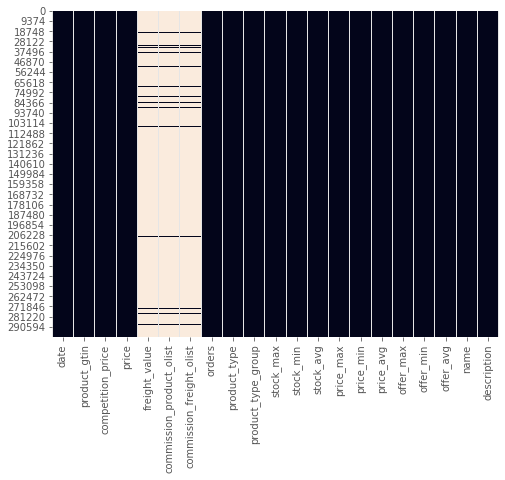

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

#### 1.4 Artificial columns and missing values:

Let's fill the empty values when needed and create some other columns that might be interesting to our analysis.  

Missing values:
- commissions: The empty commission rows will be filled with 0.20, since it is olist's default commision.

Artificial columns:
- freight_ratio: the ratio between shipping prices and the product's value. This might be problematic for product's that did not have any sales. This could be solved in a few weeks, since olist is preparing its shipping quotes historical database.  
- delta_price: percentual price difference between olist's price and competitor's price.

In [11]:
# Missing Values:

df[['commission_product_olist','commission_freight_olist']] = df[['commission_product_olist','commission_freight_olist']].fillna(value=0.20)

In [12]:
# Artificial columns:

### Freight ratio:
def freight_ratio(row):
    shipping = row['freight_value']
    price = row['price']
    if np.isnan(shipping):
        ratio = np.nan
    else:
        ratio = round(shipping / price, 3)
    
    return ratio


df['freight_ratio'] = df.apply(freight_ratio, axis=1)
#df['freight_ratio'] = df.freight_ratio.fillna(value=df.freight_ratio.mean())


### Delta price
df['delta_price'] = (df.price.values / df.competition_price.values) - 1

In [13]:
df.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description,freight_ratio,delta_price
0,2016-10-03,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,NaN,0.058858
1,2016-10-04,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,NaN,0.058858
2,2016-10-05,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,NaN,0.058858
3,2016-10-06,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,NaN,0.058858
4,2016-10-07,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,NaN,0.058858


#### 1.5 Summary Statistics:

From the summary statistics table below, we can observe a few interesting patterns:  
- For olist and competition prices, we observe similar values for every statistic, with olist prices apparently being slightly higher.  
- For commisions (over products and freight value), we see a similar mean and quartiles values. Olist's default commision is set to 0.20.  
- The orders column, which may be the most important for our analysis, we notice that most of the days have zero orders. This indicates a significant sparsity in our orders.
- For delta price, we observe that olist's price is, on average, 3% higher than its competitors'. One major issue with the data gathering process is that some of the competitor's prices are olist's prices itself. This happens when olist is the only vendor for a given product, or has the lowest price in the marketplace.

In [51]:
df.describe().round(2)

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,freight_ratio,delta_price,days
count,299941.00,299941.00,18775.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,18775.00,299941.00,299941.0
mean,225.83,230.60,21.43,0.20,0.20,0.14,947.99,781.91,866.69,259.58,256.31,258.45,232.73,228.59,230.71,0.29,0.03,1.0
std,385.85,397.31,18.14,0.00,0.01,1.00,11724.94,11062.90,11301.07,433.64,430.36,432.76,401.33,393.73,397.47,0.25,0.15,0.0
min,6.99,6.97,0.00,0.09,0.00,0.00,0.00,0.00,0.00,6.99,6.99,6.99,6.99,6.92,6.97,0.00,-0.87,1.0
25%,65.00,65.00,12.16,0.20,0.20,0.00,5.00,1.00,4.00,79.00,76.80,78.47,65.81,64.99,65.00,0.13,0.00,1.0
50%,129.99,134.90,18.12,0.20,0.20,0.00,14.00,5.00,11.38,150.64,150.00,150.00,137.99,134.00,134.90,0.23,0.00,1.0
75%,239.90,240.00,25.08,0.20,0.20,0.00,99.00,80.00,97.00,288.80,279.99,282.00,243.99,239.99,240.00,0.39,0.01,1.0
max,7406.30,7387.78,344.70,0.25,0.25,91.00,246225.00,246225.00,246225.00,7406.30,7406.30,7406.30,7406.30,7332.24,7387.78,3.29,5.07,1.0


<a name="univariate"></a>
### 2. Univariate analysis

We now explore some of our variables behaviours, most notably:  
- prices (competitor's, olist's and delta)
- shipping values (freight_values and freight_ratio)
- product types and groups (categorical)
- orders

#### 2.1 Prices

We see below how olist's and its competitors match overall. The prices are highly skewed, so we display them log transformed as well.  
The behavior of olist's prices is very similar to its competitors' prices. On the delta prices plot, we observe that most of prices differences is close to 0%. We also observe that olist's prices tend to be a little bit higher then its competitors'.

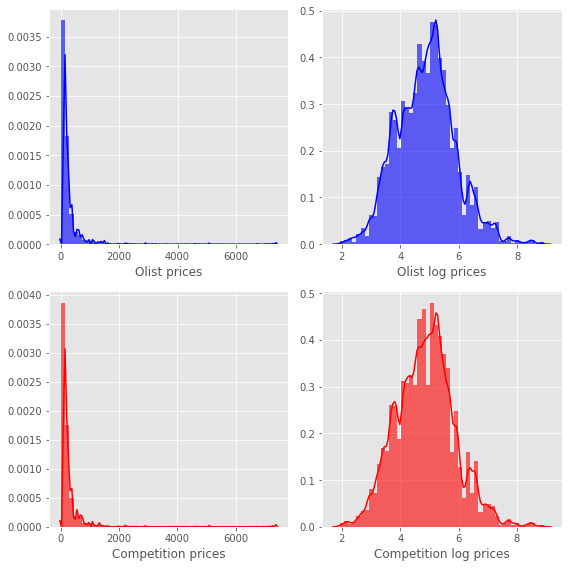

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

sns.distplot(df.price, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0][0])
ax[0][0].set_xlabel("Olist prices")
sns.distplot(np.log(df.price), hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0][1])
ax[0][1].set_xlabel("Olist log prices")

sns.distplot(df.competition_price, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1][0])
ax[1][0].set_xlabel("Competition prices")
sns.distplot(np.log(df.competition_price), hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1][1])
ax[1][1].set_xlabel("Competition log prices")

plt.tight_layout()
plt.show()

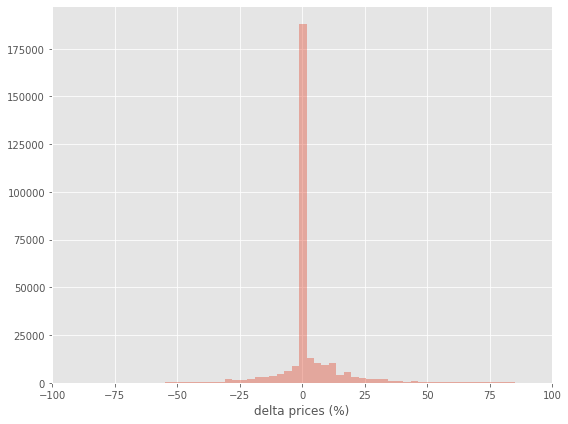

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df.delta_price*100, kde=False, bins=200, ax=ax)
plt.xlabel('delta prices (%)')
plt.xlim((-100,100))
plt.tight_layout()
plt.show()

#### 2.2 Normalized Prices Grouped by Gtin, Product Type and Product Type Group.

As we have many different products with different prices in our dataset, we could see the  prices normalized by  gtin, product_type and product_type_group.

*2.2.1 - by gtin:*

The histograms for the prices and competition_prices scaled by gtin shows a strong concentration of the data at the extremes.

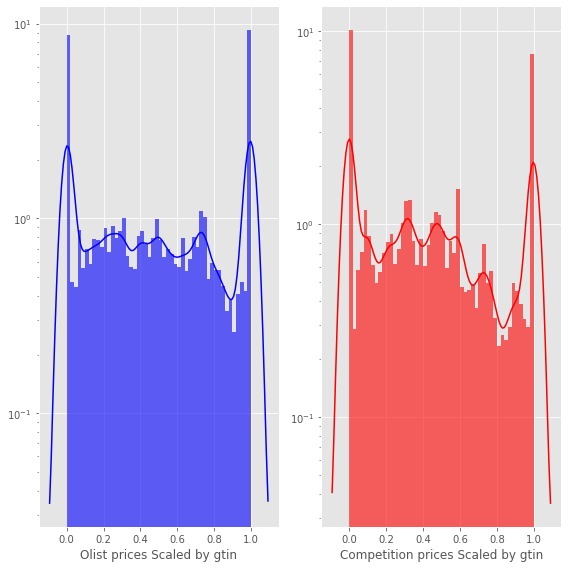

In [17]:
price_sc = df.groupby('product_gtin').price.transform(lambda x: minmax_scale(x.astype(float)))
competition_sc = df.groupby('product_gtin').competition_price.transform(lambda x: minmax_scale(x.astype(float)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

sns.distplot(price_sc, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0])
ax[0].set_xlabel("Olist prices Scaled by gtin")
ax[0].set_yscale("log")

sns.distplot(competition_sc, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1])
ax[1].set_xlabel("Competition prices Scaled by gtin")
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

*2.2.2 - by product_type:*

A little diferent from the gtin group, the product_type group show a far from normal distribution, but we can see more data in the middle of the extremes.

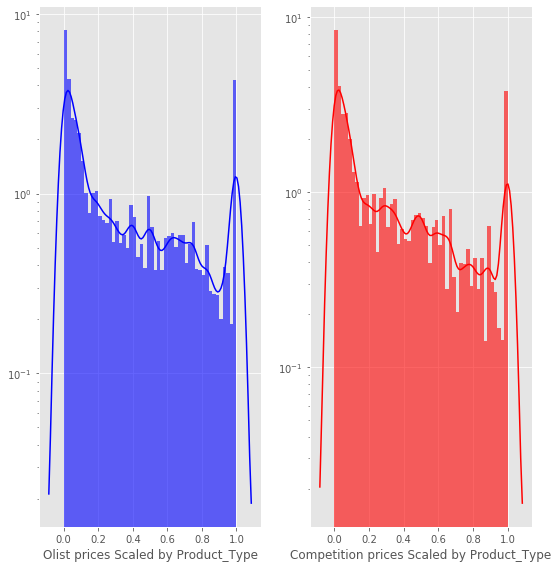

In [18]:
price_sc = df.groupby('product_type').price.transform(lambda x: minmax_scale(x.astype(float)))
competition_sc = df.groupby('product_type').competition_price.transform(lambda x: minmax_scale(x.astype(float)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

sns.distplot(price_sc, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0])
ax[0].set_xlabel("Olist prices Scaled by Product_Type")
ax[0].set_yscale("log")

sns.distplot(competition_sc, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1])
ax[1].set_xlabel("Competition prices Scaled by Product_Type")
ax[1].set_yscale("log")


plt.tight_layout()
plt.show()

*2.2.3 - by product_type_group:*

We are still far from a normal distribution, but each level of group se go up, more data we see at the middle. 

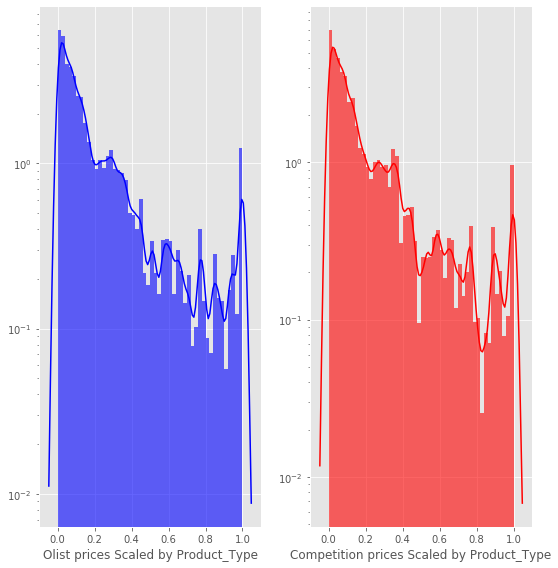

In [19]:
price_sc = df.groupby('product_type_group').price.transform(lambda x: minmax_scale(x.astype(float)))
competition_sc = df.groupby('product_type_group').competition_price.transform(lambda x: minmax_scale(x.astype(float)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

sns.distplot(price_sc, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0])
ax[0].set_xlabel("Olist prices Scaled by Product_Type")
ax[0].set_yscale("log")

sns.distplot(competition_sc, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1])
ax[1].set_xlabel("Competition prices Scaled by Product_Type")
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

#### 2.3 Shipping: values and ratio

We see a lot of products with freight value equals to zero, but as we mentioned later this could be due to the fact that the database only contains freight info if the product was added to the cart and the freight value was calculated.

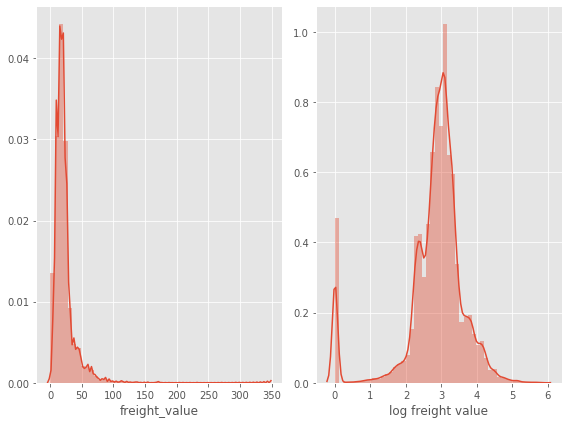

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(8,6))

sns.distplot(df.freight_value, ax=ax[0])

sns.distplot(np.log(df.freight_value+1), ax=ax[1])
ax[1].set_xlabel('log freight value')

plt.tight_layout()

Also, we can see that there are lots of outliers in freight values, but the median value is around R$ 25 

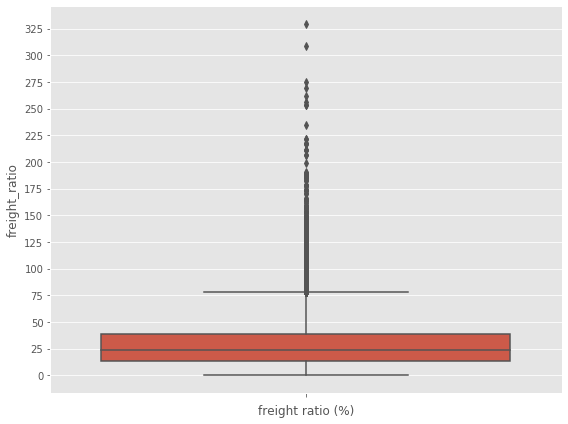

count    18775.00
mean        29.49
std         25.24
min          0.00
25%         12.95
50%         23.20
75%         38.90
max        329.40
Name: freight_ratio, dtype: float64


In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(y=df.freight_ratio*100, ax=ax)
plt.xlabel('freight ratio (%)')
plt.yticks(range(0,350,25))
plt.tight_layout()
plt.show()

print((df.freight_ratio*100).describe().round(2))

#### 2.4 Scaled Shipping: values - Grouped by gtin, product_type and product_type_group

*2.4.1 - by product_gtin:*

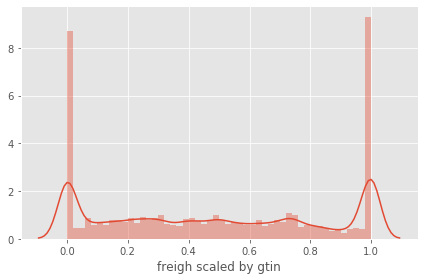

In [22]:
freight_sc = df.groupby('product_gtin').price.transform(lambda x: minmax_scale(x.astype(float)))

sns.distplot(freight_sc)
plt.xlabel('freigh scaled by gtin')
plt.tight_layout()

*2.4.2 - by product_type:*

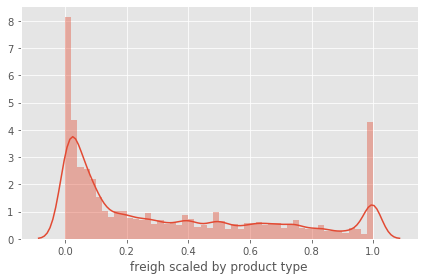

In [23]:
freight_sc = df.groupby('product_type').price.transform(lambda x: minmax_scale(x.astype(float)))

sns.distplot(freight_sc)
plt.xlabel('freigh scaled by product type')
plt.tight_layout()

*2.4.3 - by product_type_group:*

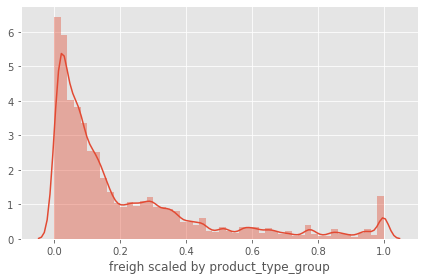

In [24]:
freight_sc = df.groupby('product_type_group').price.transform(lambda x: minmax_scale(x.astype(float)))

sns.distplot(freight_sc)
plt.xlabel('freigh scaled by product_type_group')
plt.tight_layout()

#### 2.5 Orders


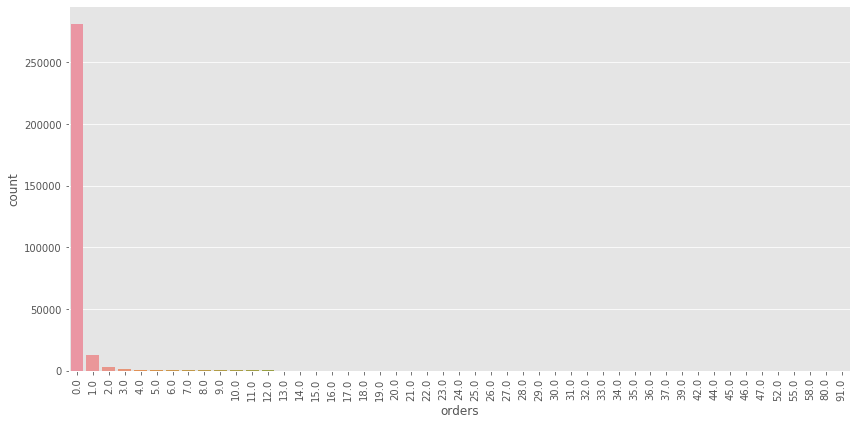

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(df.orders.round(0), ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

<a name="bivariate"></a>
### 3. Bivariate Analysis

Our main focus of this EDA is to understand what drives order quantities.  
1. Freight Value (how does free shipping impact our sales)  
2. Relationship to competitor's prices
3. Orders Seasonality

First, let's see the amount of orders per group of products

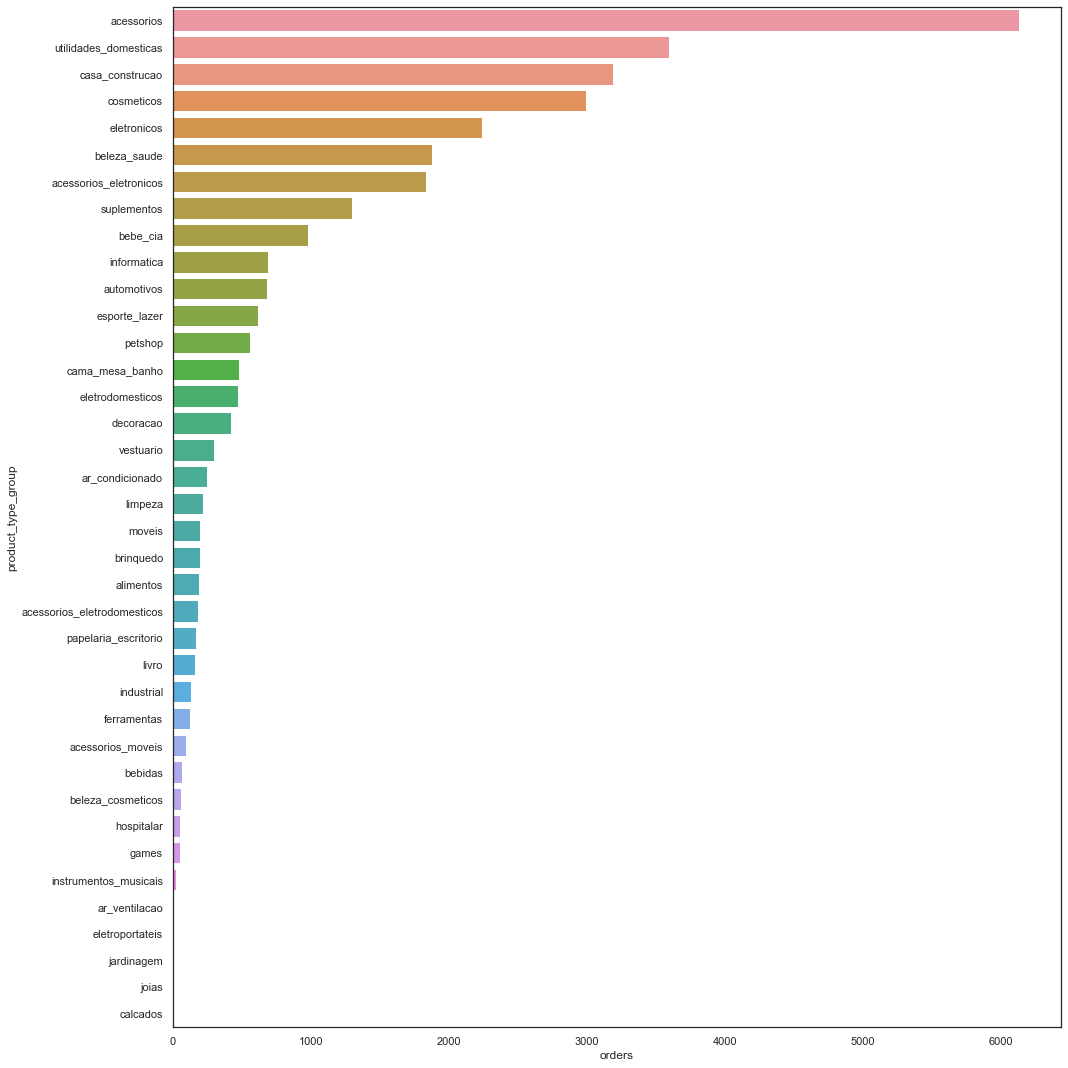

In [117]:
groups = df.groupby('product_type_group')['orders'].sum().reset_index()
groups = groups.sort_values(by=['orders'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(15,15))
sns.barplot(x='orders', y='product_type_group', data=groups, orient = 'h') 
plt.tight_layout()    

Now, let's see how orders are correlated with other variables

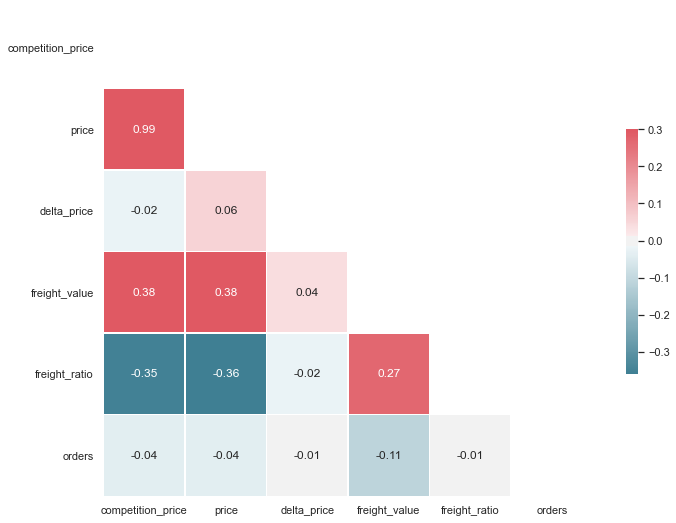

In [58]:
sns.set(style="white")

corr = df[['competition_price','price','delta_price',
           'freight_value','freight_ratio','orders']].corr().round(2)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

#### 3.1 Prices x Orders

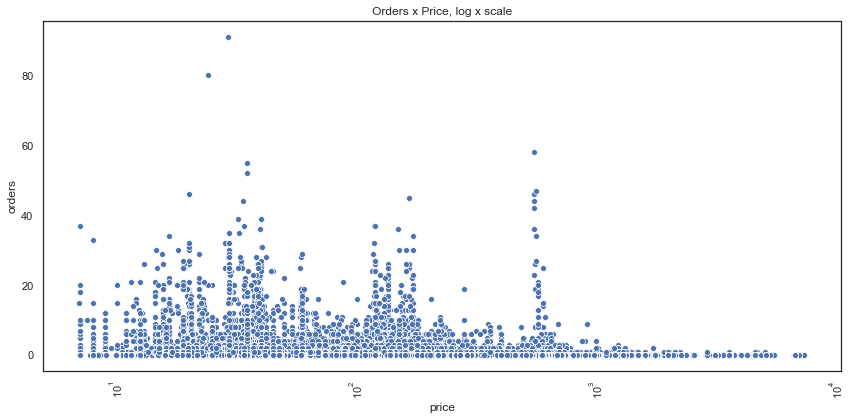

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x = 'price', y = 'orders', data = df, ax=ax)
plt.title('Orders x Price, log x scale')
plt.xscale('log')
plt.xticks(rotation=90)
plt.tight_layout()

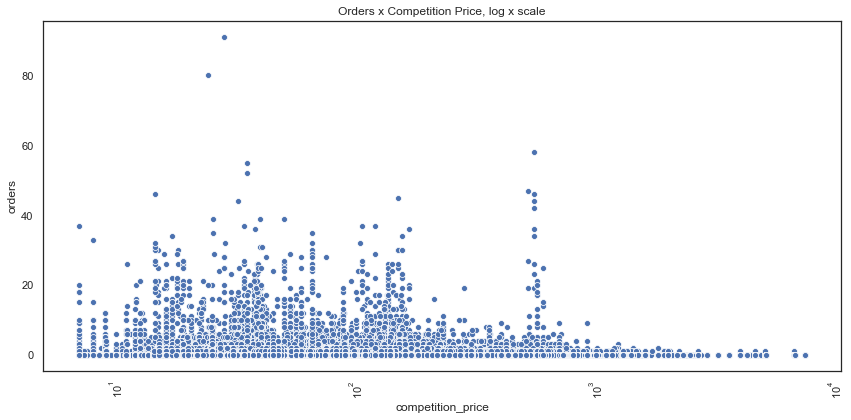

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x = 'competition_price', y = 'orders', data = df, ax=ax)
plt.title('Orders x Competition Price, log x scale')
plt.xscale('log')
plt.xticks(rotation=90)
plt.tight_layout()

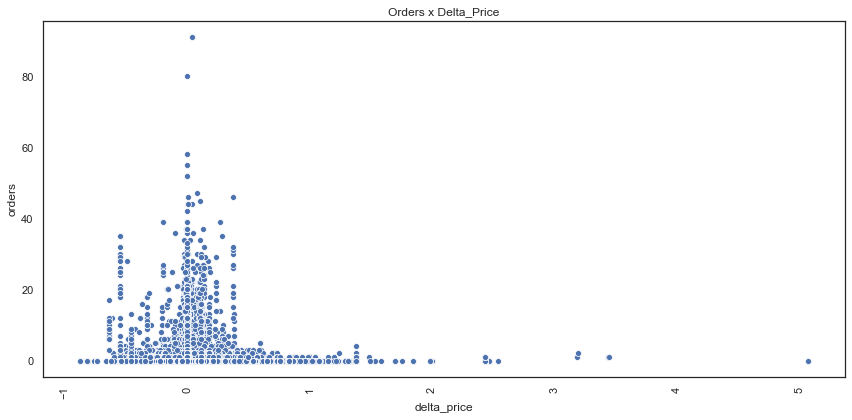

In [84]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x = 'delta_price', y = 'orders', data = df, ax=ax)
plt.title('Orders x Delta_Price')
plt.xticks(rotation=90)
plt.tight_layout()

Transforming Delta Price in Category

In [87]:
bins = [-1, 0, 0.5, 0.8, 1, np.inf]
names = ['<0', '0-0.5', '0.5-0.8', '0.8-1', '1+']

df['delta_price_cat'] = pd.cut(df['delta_price'], bins, labels=names)

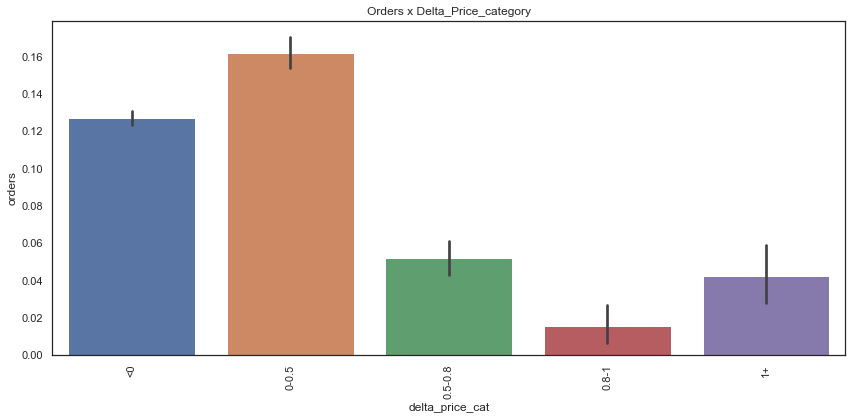

In [93]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x = 'delta_price_cat', y = 'orders', data = df, ax=ax)
plt.title('Orders x Delta_Price_category')
plt.xticks(rotation=90)
plt.tight_layout()

As expected, most of the orders is made when delta price is <0, which means Olist Price is lower than competition price.

#### 3.2 Orders Seasonality

Let's create 3 more variables trying to understand eventual Seasonality of the data:
- weekday
- monthday
- month

In [93]:
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['monthday'] = pd.DatetimeIndex(df['date']).day
df['month'] = pd.DatetimeIndex(df['date']).month

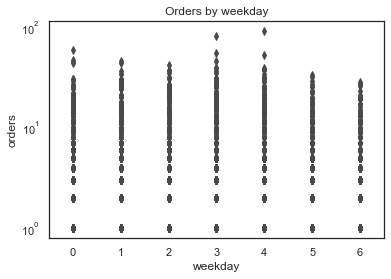

In [28]:
sns.boxplot(x='weekday', y='orders',  data=df).set_title('Orders by weekday')
plt.yscale('log')

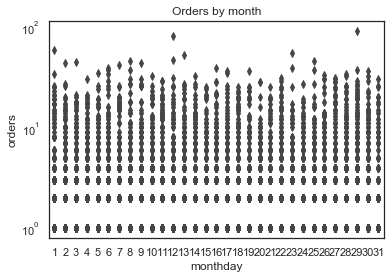

In [29]:
sns.boxplot(x='monthday', y='orders',  data=df).set_title('Orders by month')
plt.yscale('log')

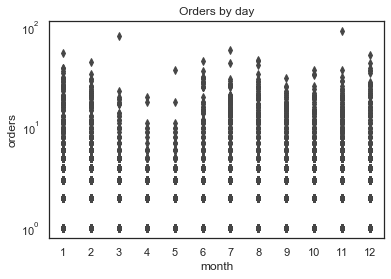

In [30]:
sns.boxplot(x='month', y='orders',  data=df).set_title('Orders by day')
plt.yscale('log')

<a name="sparsity"></a>
### 4. Demand sparsity

Olist offers many long-tail products, i.e. hard to find products, that are sold in low volumes to many customers. To mitigate this problem, let's first analyze the top selling products/categories.

##### Products

In [31]:
df['days'] = 1

In [32]:
sparsity = df.groupby('product_gtin')[['orders','days']].sum().reset_index()

sparsity['orders_per_day'] = sparsity['orders'].values / sparsity['days'].values

sparsity = sparsity.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity.describe()

,orders,days,orders_per_day
count,644.000000,644.000000,644.000000
mean,63.119565,465.746894,0.135026
std,211.872485,326.266647,0.427785
min,1.000000,56.000000,0.001014
25%,4.000000,208.750000,0.013202
50%,13.000000,374.500000,0.037566
75%,44.250000,631.750000,0.099235
max,2859.000000,1360.000000,5.529255


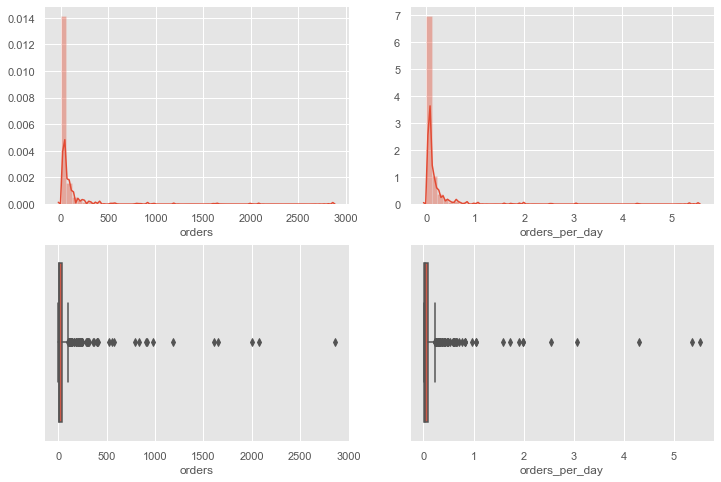

In [33]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.distplot(sparsity.orders, ax=ax[0][0])
sns.distplot(sparsity.orders_per_day, ax=ax[0][1])

sns.boxplot(sparsity.orders, ax=ax[1][0])
sns.boxplot(sparsity.orders_per_day, ax=ax[1][1])

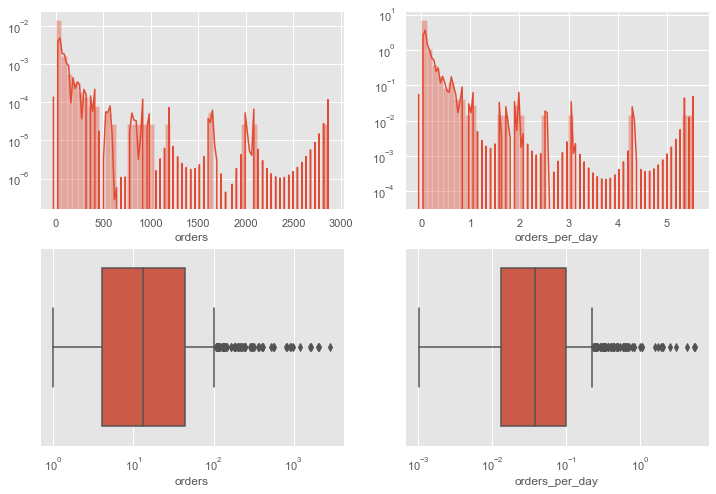

In [34]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.distplot(sparsity.orders, ax=ax[0][0])
ax[0][0].set_yscale('log')

sns.distplot(sparsity.orders_per_day, ax=ax[0][1])
ax[0][1].set_yscale('log')

sns.boxplot(sparsity.orders, ax=ax[1][0])
ax[1][0].set_xscale('log')
sns.boxplot(sparsity.orders_per_day, ax=ax[1][1])
ax[1][1].set_xscale('log')

##### Product types

In [35]:
sparsity_ty = df.groupby('product_type')[['orders','days']].sum().reset_index()

sparsity_ty['orders_per_day'] = sparsity_ty['orders'].values / sparsity_ty['days'].values

sparsity_ty = sparsity_ty.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_ty.describe()

,orders,days,orders_per_day
count,251.000000,251.000000,251.000000
mean,161.948207,1194.984064,0.157727
std,707.666753,5453.613375,0.449602
min,1.000000,77.000000,0.001561
25%,7.000000,315.000000,0.015828
50%,26.000000,613.000000,0.042254
75%,93.000000,1114.500000,0.117736
max,10077.000000,85806.000000,5.529255


In [36]:
sparsity_ty.head(5)

,product_type,orders,days,orders_per_day
0,non-classified,10077.0,85806,0.117439
1,Lanterna,2874.0,1384,2.076590
2,Kit maquiagem,2079.0,376,5.529255
3,Transformador de energia,1999.0,1151,1.736751
4,Suporte para tv,1692.0,1357,1.246868


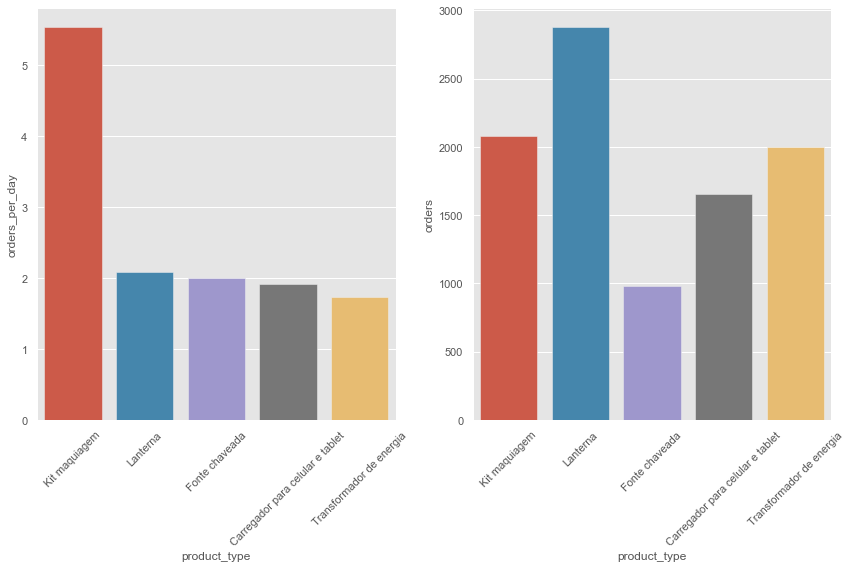

In [37]:
temp = sparsity_ty.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type.head(),rotation=45)


plt.tight_layout()

plt.show()

##### Product groups

In [38]:
sparsity_gr = df.groupby('product_type_group')[['orders','days']].sum().reset_index()

sparsity_gr['orders_per_day'] = sparsity_gr['orders'].values / sparsity_gr['days'].values

sparsity_gr = sparsity_gr.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_gr.describe()

,orders,days,orders_per_day
count,39.000000,39.000000,39.000000
mean,1042.282051,7690.794872,0.165375
std,1960.489707,14126.719728,0.292735
min,2.000000,342.000000,0.001561
25%,81.000000,1281.000000,0.031865
50%,222.000000,3737.000000,0.065848
75%,834.500000,8064.500000,0.151163
max,10077.000000,85806.000000,1.662738


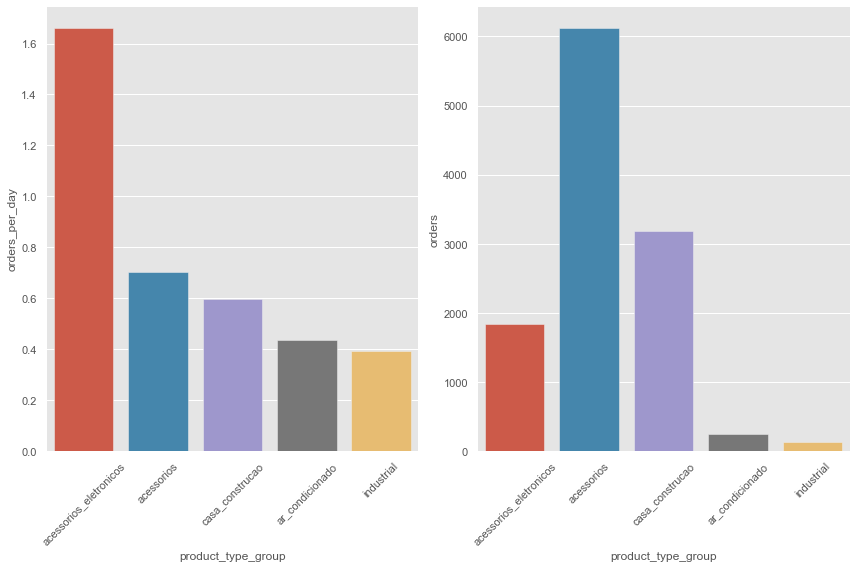

In [39]:
temp = sparsity_gr.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type_group.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type_group.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type_group.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type_group.head(),rotation=45)


plt.tight_layout()

plt.show()

In [40]:
sparsity_gr.sort_values(by='orders_per_day', ascending=False).head(5)

,product_type_group,orders,days,orders_per_day
7,acessorios_eletronicos,1834.0,1103,1.662738
1,acessorios,6129.0,8721,0.702786
3,casa_construcao,3189.0,5342,0.596967
18,ar_condicionado,246.0,566,0.434629
26,industrial,134.0,342,0.391813


<a name="gtin"></a>
### 6. GTIN Analysis

#### 6.1 Product 1: Make-up kit
Let's choose a single product_type: makeup kit.  
It contains the largest average of orders per day (~5)

In [126]:
sparsity_ty.groupby('product_type')['orders_per_day'].max().sort_values(ascending=False)

product_type
Kit maquiagem                       5.529255
Lanterna                            2.076590
Fonte chaveada                      1.997955
Carregador para celular e tablet    1.907621
Transformador de energia            1.736751
                                      ...   
Caneta                              0.002857
Chapa                               0.002488
Pedal para instrumentos             0.001587
Bota                                0.001561
Brinco                              0.001561
Name: orders_per_day, Length: 250, dtype: float64

In [41]:
makeup = df[df.product_type == 'Kit maquiagem'].copy().reset_index(drop=True)

In [42]:
df.product_type_group[df.product_type == 'Kit maquiagem'].unique()

array(['cosmeticos'], dtype=object)

In [43]:
df.product_type[df.product_type_group == 'cosmeticos'].unique()

array(['Perfume', 'Máscara de tratamento', 'Kit maquiagem', 'Sérum',
       'Shampoo', 'Coloração', 'Progressiva para cabelos',
       'Óleo essencial', 'Maleta de maquiagem', 'Base de unha'],
      dtype=object)

In [44]:
makeup.product_gtin.nunique()

1

In [45]:
makeup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      376 non-null    object 
 1   product_gtin              376 non-null    object 
 2   competition_price         376 non-null    float64
 3   price                     376 non-null    float64
 4   freight_value             281 non-null    float64
 5   commission_product_olist  376 non-null    float64
 6   commission_freight_olist  376 non-null    float64
 7   orders                    376 non-null    float64
 8   product_type              376 non-null    object 
 9   product_type_group        376 non-null    object 
 10  stock_max                 376 non-null    float64
 11  stock_min                 376 non-null    float64
 12  stock_avg                 376 non-null    float64
 13  price_max                 376 non-null    float64
 14  price_min 

In [46]:
makeup.describe()

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,freight_ratio,delta_price,weekday,monthday,month,days
count,376.000000,376.000000,281.000000,376.000000,376.000000,376.000000,376.00000,376.000000,376.000000,3.760000e+02,3.760000e+02,3.760000e+02,376.000000,376.000000,376.000000,281.000000,3.760000e+02,376.000000,376.000000,376.000000,376.0
mean,135.058644,140.784185,28.576118,0.184884,0.184884,5.529255,636.68883,595.071809,616.400485,1.699000e+02,1.699000e+02,1.699000e+02,141.655319,140.493085,140.881673,0.203224,4.493648e-02,3.013298,15.763298,6.433511,1.0
std,9.027437,10.259440,10.491495,0.019158,0.019158,6.194983,410.08069,433.051680,418.349112,9.960853e-13,9.960853e-13,1.000480e-12,11.196605,10.456098,10.235680,0.079169,7.776052e-02,1.999289,8.963323,3.444934,0.0
min,105.510000,117.486552,0.000000,0.160000,0.160000,0.000000,5.00000,0.000000,5.000000,1.699000e+02,1.699000e+02,1.699000e+02,119.900000,119.900000,119.900000,0.000000,-2.942908e-01,0.000000,1.000000,1.000000,1.0
25%,131.660000,134.900000,23.050000,0.160000,0.160000,0.000000,303.25000,248.000000,268.574761,1.699000e+02,1.699000e+02,1.699000e+02,134.900000,134.900000,134.900000,0.158000,0.000000e+00,1.000000,8.000000,3.000000,1.0
50%,134.900000,134.900000,27.888333,0.200000,0.200000,4.000000,493.00000,489.000000,489.500000,1.699000e+02,1.699000e+02,1.699000e+02,134.900000,134.900000,134.900000,0.192000,2.220446e-16,3.000000,16.000000,6.000000,1.0
75%,137.150000,153.233333,33.032500,0.200000,0.200000,8.000000,985.25000,952.500000,959.931818,1.699000e+02,1.699000e+02,1.699000e+02,154.900000,154.900000,154.900000,0.245000,7.971041e-02,5.000000,24.000000,9.000000,1.0
max,169.900000,156.900000,64.470000,0.200000,0.200000,37.000000,1501.00000,1488.000000,1492.833333,1.699000e+02,1.699000e+02,1.699000e+02,169.900000,156.900000,156.900000,0.457000,2.710592e-01,6.000000,31.000000,12.000000,1.0


In [47]:
makeup.corr().round(3)[['orders']]

,orders
competition_price,-0.316
price,-0.116
freight_value,-0.334
commission_product_olist,-0.287
commission_freight_olist,-0.287
orders,1.000
stock_max,0.159
stock_min,0.146
stock_avg,0.173
price_max,0.000


Now, we see that both freight ratio and freight value columns have negative correlations with orders. That could indicate that offering free shipping might have a bigger impact on sales.  
If we observe the delta_price correlation we might consider that having a higher price than our competitors may not hinder our competitiveness.  

Let's analyze our timeseries behavior:

In [48]:
columns = ['competition_price', 'price', 'freight_value','orders', 'stock_max'] 

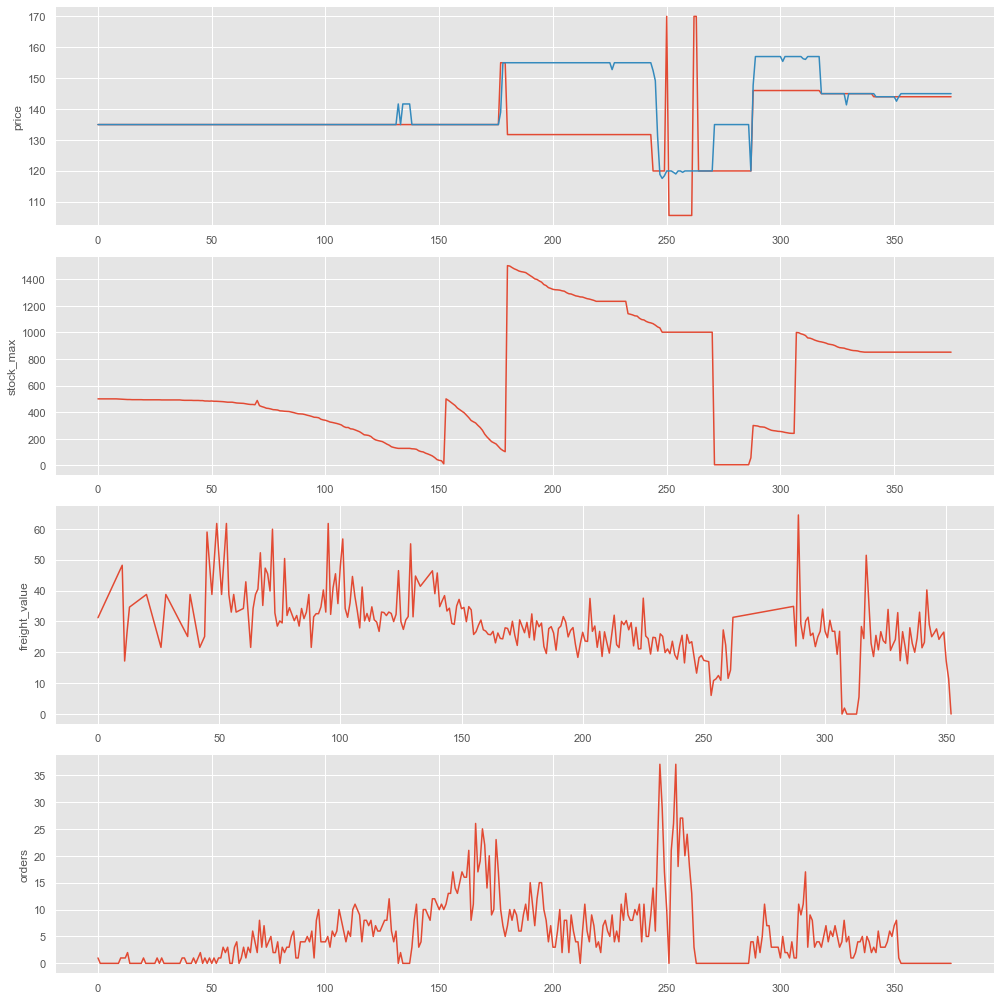

In [49]:
sns.set_style()

fig, ax = plt.subplots(nrows=4, figsize=(14,14))

sns.lineplot(x=makeup.index, y=makeup['competition_price'], ax=ax[0])
sns.lineplot(x=makeup.index, y=makeup['price'], ax=ax[0])


sns.lineplot(x=makeup.index, y=makeup['stock_max'], ax=ax[1])

sns.lineplot(x=makeup.index, y=makeup['freight_value'], ax=ax[2])

sns.lineplot(x=makeup.index, y=makeup['orders'], ax=ax[3])


plt.tight_layout()

Looking at the above plot, we can observe a few interesting things: the period in which we have the most sales is a few weeks before Christmas; The period without sales from mid December 2019 to January is the same period when our stocks are the lowest (around 5 units); We observe that from Jan 28th to Feb 3, there was a small rise in sales when the shipping values were 0 (free shipping); 

In [50]:
makeup.name[0]

'Maleta Kit Maquiagem Profissional Completa Ruby Rose'

In [51]:
makeup.product_gtin[0]

'7899495703106'

Evaluating Seasonality

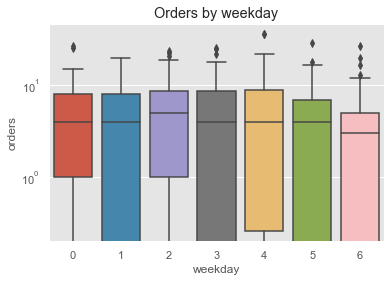

In [52]:
sns.boxplot(x='weekday', y='orders',  data=makeup).set_title('Orders by weekday')
plt.yscale('log')

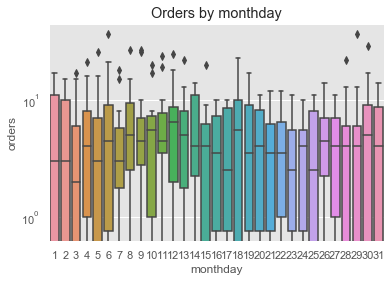

In [53]:
sns.boxplot(x='monthday', y='orders',  data=makeup).set_title('Orders by monthday')
plt.yscale('log')

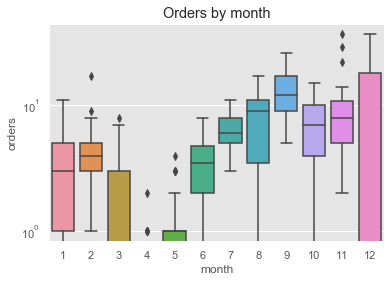

In [54]:
sns.boxplot(x='month', y='orders',  data=makeup).set_title('Orders by month')
plt.yscale('log')

Evaluating the correlation between variables

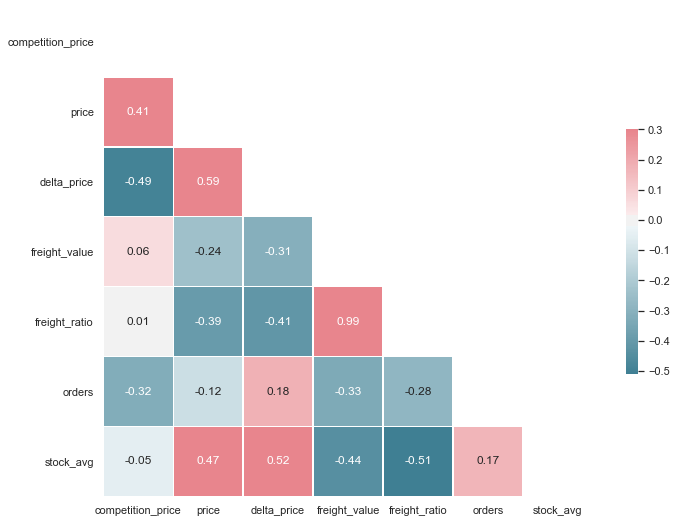

In [55]:
sns.set(style="white")

corr = makeup[['competition_price','price','delta_price',
           'freight_value','freight_ratio','orders', 'stock_avg']].corr().round(2)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<a name="product_type_group"></a>
### 7. Product Type Group Analysis

#### 7.1 Product Type Group 1: Cosmetic
Let's choose a single product_type_group: Electronic Accessories (acessorios_eletronicos).  
It contains the largest average of orders per day (~2)

In [56]:
elect_accessories = df[df.product_type_group == 'acessorios_eletronicos'].copy().reset_index(drop=True)

In [57]:
elect_accessories.product_gtin.nunique()

2

In [58]:
elect_accessories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1103 non-null   object 
 1   product_gtin              1103 non-null   object 
 2   competition_price         1103 non-null   float64
 3   price                     1103 non-null   float64
 4   freight_value             316 non-null    float64
 5   commission_product_olist  1103 non-null   float64
 6   commission_freight_olist  1103 non-null   float64
 7   orders                    1103 non-null   float64
 8   product_type              1103 non-null   object 
 9   product_type_group        1103 non-null   object 
 10  stock_max                 1103 non-null   float64
 11  stock_min                 1103 non-null   float64
 12  stock_avg                 1103 non-null   float64
 13  price_max                 1103 non-null   float64
 14  price_mi

In [59]:
elect_accessories.describe()

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,freight_ratio,delta_price,weekday,monthday,month,days
count,1103.000000,1103.000000,316.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,316.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.0
mean,58.608513,56.050278,15.593188,0.195829,0.195829,1.662738,145.270172,98.333636,122.960996,71.610100,69.224832,70.666610,56.440236,54.959492,55.700357,0.412820,0.012825,3.007253,15.802357,6.412511,1.0
std,22.850627,20.967568,6.241807,0.010952,0.010952,4.751209,292.167079,240.126969,256.307230,26.509153,28.332917,26.992162,21.364265,21.662996,21.255158,0.226639,0.378114,1.998625,8.854998,3.788571,0.0
min,14.500000,15.990000,5.620000,0.160000,0.160000,0.000000,0.000000,0.000000,0.000000,15.990000,14.500000,15.990000,15.990000,14.500000,15.990000,0.069000,-0.762954,0.000000,1.000000,1.000000,1.0
25%,51.180000,55.920000,11.384176,0.200000,0.200000,0.000000,3.000000,2.000000,2.250000,79.000000,55.990000,59.900000,55.930000,54.910000,54.910000,0.233500,-0.040445,1.000000,8.000000,3.000000,1.0
50%,59.900000,59.900000,14.738571,0.200000,0.200000,0.000000,5.000000,5.000000,5.000000,79.900000,79.900000,79.900000,59.900000,59.900000,59.900000,0.346000,0.000000,3.000000,16.000000,6.000000,1.0
75%,79.900000,59.900000,18.760000,0.200000,0.200000,1.000000,96.000000,38.000000,75.000000,79.900000,79.900000,79.900000,59.900000,59.900000,59.900000,0.575750,0.000000,5.000000,23.000000,10.000000,1.0
max,99.900000,100.000000,57.000000,0.200000,0.200000,46.000000,1000.000000,1000.000000,1000.000000,120.000000,115.990000,118.440556,100.000000,94.900000,96.997500,1.377000,3.442546,6.000000,31.000000,12.000000,1.0


In [60]:
elect_accessories.corr().round(3)[['orders']]

,orders
competition_price,-0.455
price,-0.453
freight_value,-0.283
commission_product_olist,-0.137
commission_freight_olist,-0.137
orders,1.000
stock_max,0.347
stock_min,0.310
stock_avg,0.366
price_max,-0.455


TO DO: insert comments

Let's analyze our timeseries behavior:

In [61]:
columns = ['competition_price', 'price', 'freight_value','orders', 'stock_max'] 

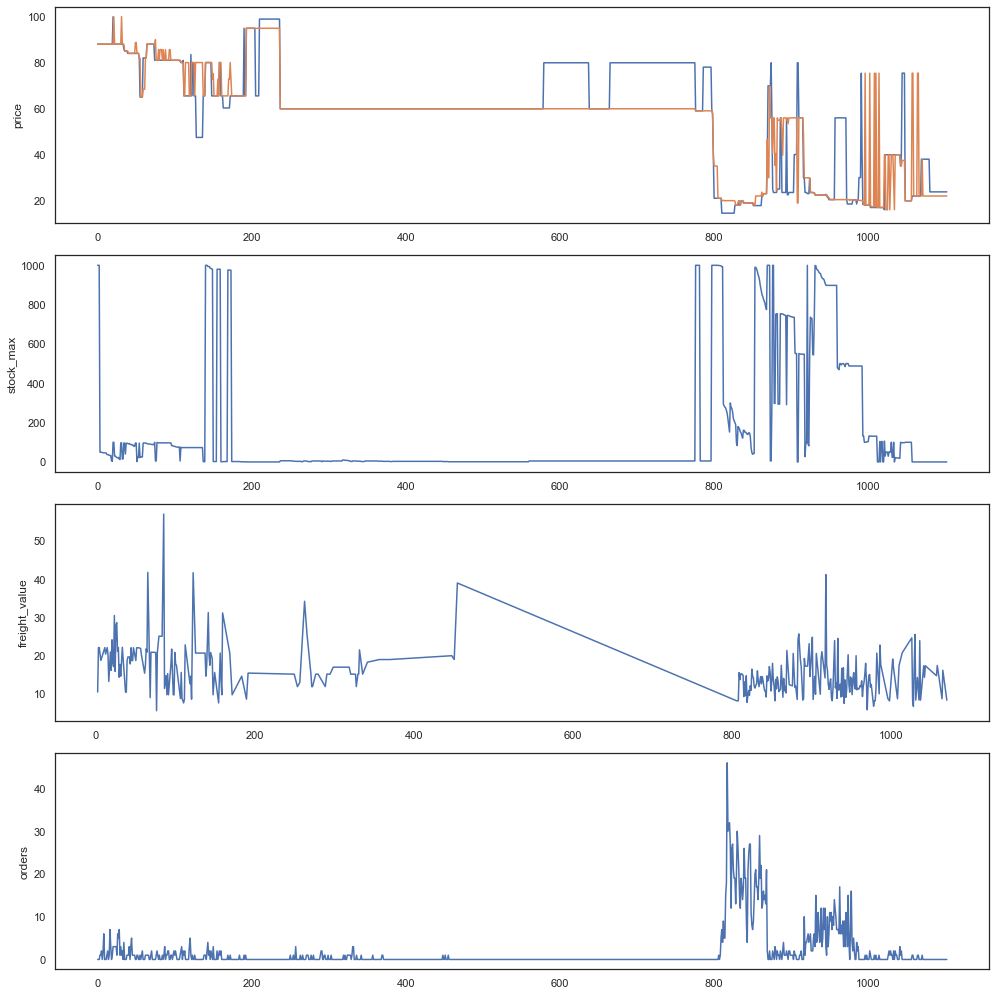

In [62]:
sns.set_style()

fig, ax = plt.subplots(nrows=4, figsize=(14,14))

sns.lineplot(x=elect_accessories.index, y=elect_accessories['competition_price'], ax=ax[0])
sns.lineplot(x=elect_accessories.index, y=elect_accessories['price'], ax=ax[0])


sns.lineplot(x=elect_accessories.index, y=elect_accessories['stock_max'], ax=ax[1])

sns.lineplot(x=elect_accessories.index, y=elect_accessories['freight_value'], ax=ax[2])

sns.lineplot(x=elect_accessories.index, y=elect_accessories['orders'], ax=ax[3])


plt.tight_layout()

In [63]:
elect_accessories.product_type.unique()

array(['Tela touch', 'Carregador para celular e tablet'], dtype=object)

In [64]:
elect_accessories.name.unique()

array(['Tela Touch Display Lcd Samsung J5 Pro J530 Brilho Dourado',
       'Carregador Turbo Para Motorola Moto G3 G4 G5 Maxx S6'],
      dtype=object)

Text(0.5, 1.0, 'Orders by Product Type inside the Group')

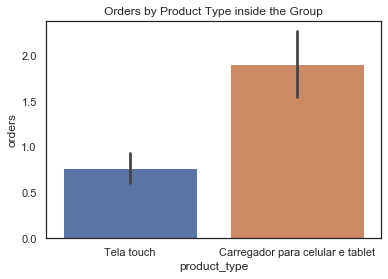

In [65]:
sns.barplot(x='product_type', y='orders',  data=elect_accessories).set_title('Orders by Product Type inside the Group')

In [66]:
elect_accessories.product_gtin.unique()

array(['6918040449489', '7895099385786'], dtype=object)

Evaluating Seasonality

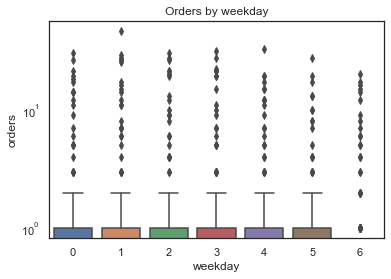

In [67]:
sns.boxplot(x='weekday', y='orders',  data=elect_accessories).set_title('Orders by weekday')
plt.yscale('log')

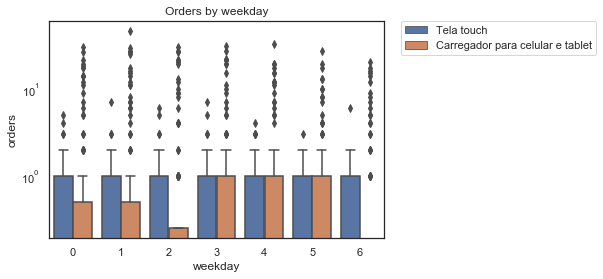

In [68]:
sns.boxplot(x='weekday', y='orders', hue = 'product_type',  data=elect_accessories).set_title('Orders by weekday')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

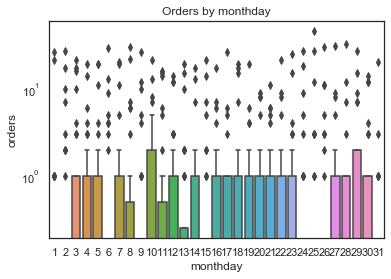

In [69]:
sns.boxplot(x='monthday', y='orders',  data=elect_accessories).set_title('Orders by monthday')
plt.yscale('log')

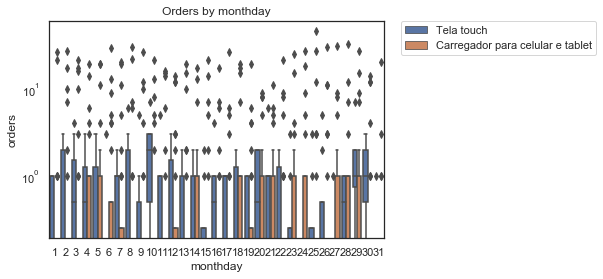

In [70]:
sns.boxplot(x='monthday', y='orders',  hue = 'product_type', data=elect_accessories).set_title('Orders by monthday')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

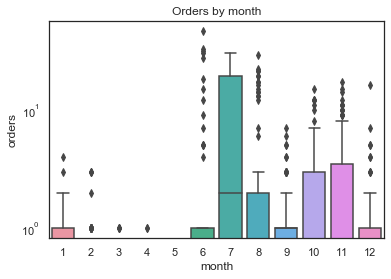

In [71]:
sns.boxplot(x='month', y='orders',  data=elect_accessories).set_title('Orders by month')
plt.yscale('log')

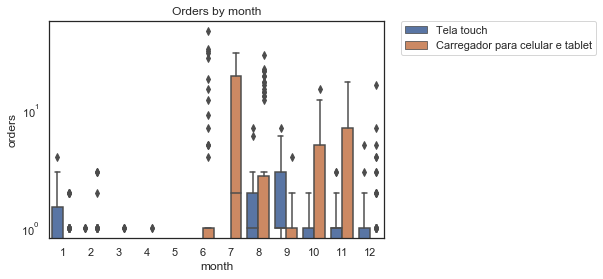

In [72]:
sns.boxplot(x='month', y='orders',  hue = 'product_type', data=elect_accessories).set_title('Orders by month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

Evaluating the correlation between variables

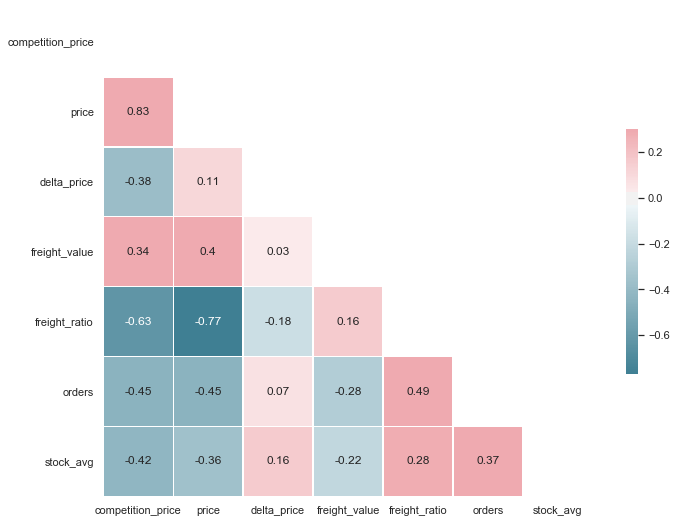

In [73]:
sns.set(style="white")

corr = elect_accessories[['competition_price','price','delta_price',
           'freight_value','freight_ratio','orders', 'stock_avg']].corr().round(2)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

TO DO: insert comments about the product_type_group